In [6]:
##import the necessary packages.

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import time

#set the random seed to obtain outcomes.
np.random.seed(0)
tf.random.set_seed(0)

## Data Generation

In [418]:
#Extract the MINIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

#change into black and white
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255



In [8]:
#Seperate the different data
#discard the label data because of unsupervised learning
digit1_train=X_train[y_train==1]
digit2_train=X_train[y_train==2]
digit3_train=X_train[y_train==3]
digit4_train=X_train[y_train==4]
digit5_train=X_train[y_train==5]
digit6_train=X_train[y_train==6]
digit7_train=X_train[y_train==7]
digit8_train=X_train[y_train==8]
digit9_train=X_train[y_train==9]
digit0_train=X_train[y_train==0]


digit1_test=X_test[y_test==1]
digit2_test=X_test[y_test==2]
digit3_test=X_test[y_test==3]
digit4_test=X_test[y_test==4]
digit5_test=X_test[y_test==5]
digit6_test=X_test[y_test==6]
digit7_test=X_test[y_test==7]
digit8_test=X_test[y_test==8]
digit9_test=X_test[y_test==9]
digit0_test=X_test[y_test==0]

In [9]:
#Define the function
#The function shifts images in a horizontal way to right.

def Shift_h(shift,inputs):
    #shift horizontally function 
    rows,cols=inputs.shape[1:3]
    data_train=[]
    for k in range(inputs.shape[0]):
        for i in range(0,shift):
            #fit the data into new position according to equation
            zeros=np.zeros((rows,cols+shift))
            zeros[:rows,i:i+cols]=inputs[k]
            data_train.append(zeros)
    data_train=np.asarray(data_train)
    return data_train

In [10]:
data_train_2=Shift_h(12,digit2_train)
data_test_2=Shift_h(12,digit2_test)

In [11]:
#Define a function to plot pixels.
def plot_image(image):
    plt.imshow(image, cmap="gray")
    plt.axis("off")

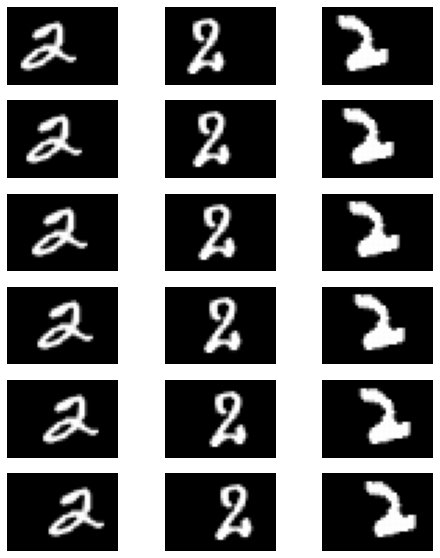

In [13]:
#Show randomly selected observations motion trajectory in frames.
fig = plt.figure(figsize=(8, 10))
index=list(range(0,12,2))
index_=list(range(0,18,3))
for image_index in range(6):
    plt.subplot(6, 3, index_[image_index]+1)
    plot_image(data_train_2[index[image_index]])
for image_index in range(6):
    plt.subplot(6, 3, index_[image_index]+2)
    plot_image(data_train_2[480+index[image_index]])
for image_index in range(6):
    plt.subplot(6, 3, index_[image_index]+3)
    plot_image(data_train_2[2400+index[image_index]])
#plt.savefig('digit2.jpg')

In [16]:
data_train_2.shape

(71496, 28, 40)

In [17]:
#Split the dataset into train and valid dataset of digit
x_train=data_train_2[:60000,:]
x_valid=data_train_2[60000:71496,:]

In [18]:
#define the loss function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [19]:
#define the Gaussian distribution according to Reparameterization Trick in order to calculate latent variable z
K = keras.backend
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [20]:
#define a function to show reconstructions according to the diversity of latent space dimensionality.
#here we only focus on the dimension of latent variable 


#Here we pre-defined the VAE layers so that the shape need to be manually adjusted
def VAE(codings_size_val):
    tf.random.set_seed(42)
    np.random.seed(42)
    ###latent space dimension
    codings_size = codings_size_val
    #Encoder
    inputs = keras.layers.Input(shape=[28, 40])          #pixels according to the inputs
    z = keras.layers.Flatten()(inputs)                   #Flatten the features
    z = keras.layers.Dense(150, activation="selu")(z)    #fully connected Layer 1
    z = keras.layers.Dense(100, activation="selu")(z)    #fully connected Layer 2
    codings_mean = keras.layers.Dense(codings_size)(z)   #Latent space
    codings_log_var = keras.layers.Dense(codings_size)(z)#Sampling Gaussian distribution
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = keras.models.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
    ###########################################################################
    #Decoder
    decoder_inputs = keras.layers.Input(shape=[codings_size])
    x = keras.layers.Dense(100, activation="selu")(decoder_inputs)     #fully connected Layer 1
    x = keras.layers.Dense(150, activation="selu")(x)                  #fully connected Layer 2
    x = keras.layers.Dense(28 * 40, activation="sigmoid")(x)           #Output Layer
    outputs = keras.layers.Reshape([28, 40])(x)
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs]) #combined encoder and decoder
    ###########################################################################
    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings) #how to structure reconstructions
    variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
    ###########################################################################
    #regularization term
    latent_loss = -0.5 * K.sum(
        1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
        axis=-1)
    variational_ae.add_loss(K.mean(latent_loss) / 1120.) 
    variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop",metrics=[rounded_accuracy])
    #return the model
    return variational_ae

In [21]:
#define a function to show reconstructions 

def show_reconstructions(model, images=x_valid, n_images=12):
    #randomly selected
    #index=np.random.randint(0,80904,12)
    #all frames of first objects
    index=list(range(12))
    reconstructions = model.predict(images[index])
    fig = plt.figure(figsize=(n_images * 3, 5))
    
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.title('Original image')
        plot_image(images[index[image_index]])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        plt.title('Reconstructed image')



## How we decide the suitable dimensionality of latent space

In [28]:
Performance_dim=[2,3,5,10]
#define a function to show reconstructions 
def performance(Performance_dim):
    Performance_loss=[]
    Performance_time=[]
    for i in Performance_dim:
        
        variational_ae=VAE(i)
        import time
        time_start=time.time()
        history = variational_ae.fit(x_train, x_train, epochs=10,
                             validation_data=(x_valid, x_valid),verbose=0)
        time_end=time.time()
        time=time_end-time_start
        Performance_time.append(time)
        Performance_loss.append(history.history['loss'][-1])
        show_reconstructions(variational_ae)
        plt.savefig('digit2_dim'+str(i)+'.jpg')
    return Performance_time,Performance_loss

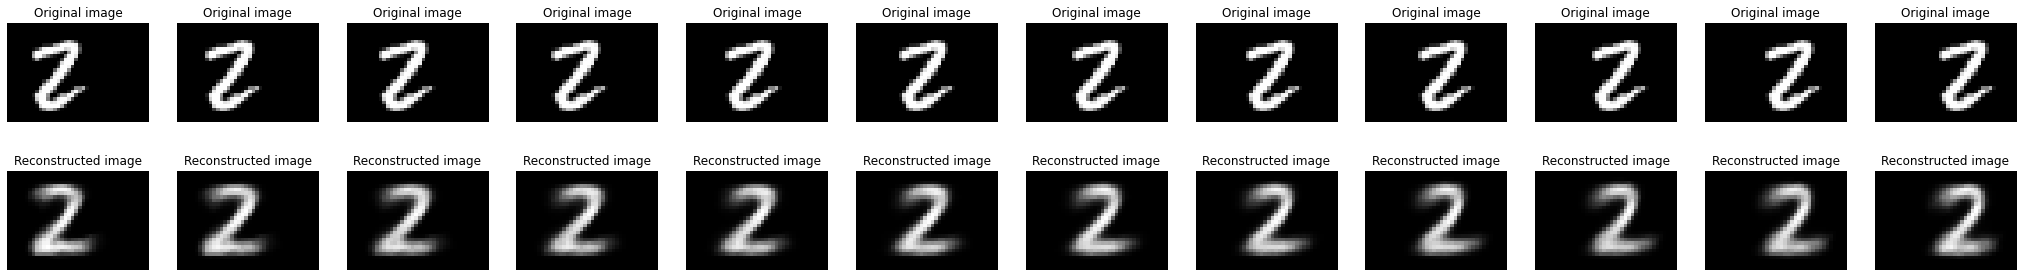

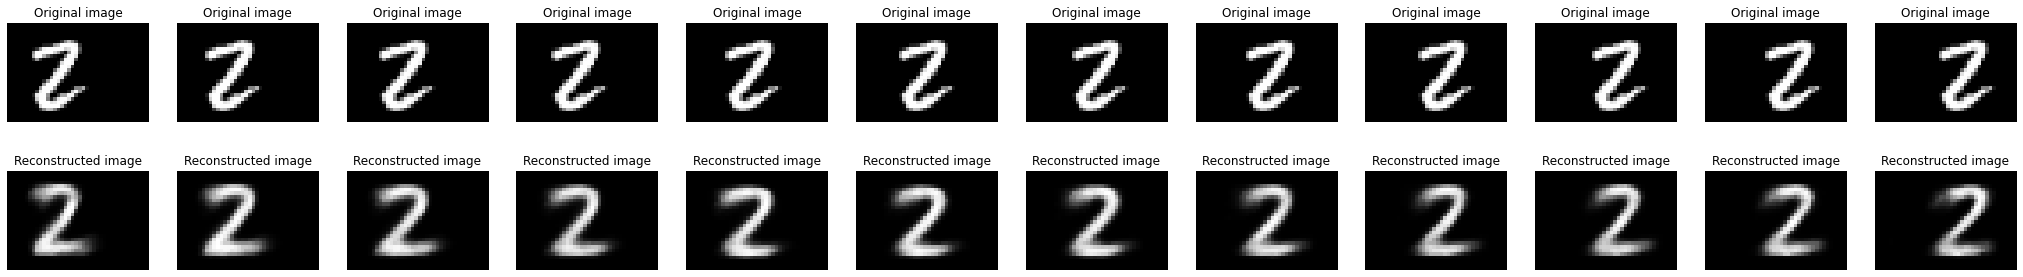

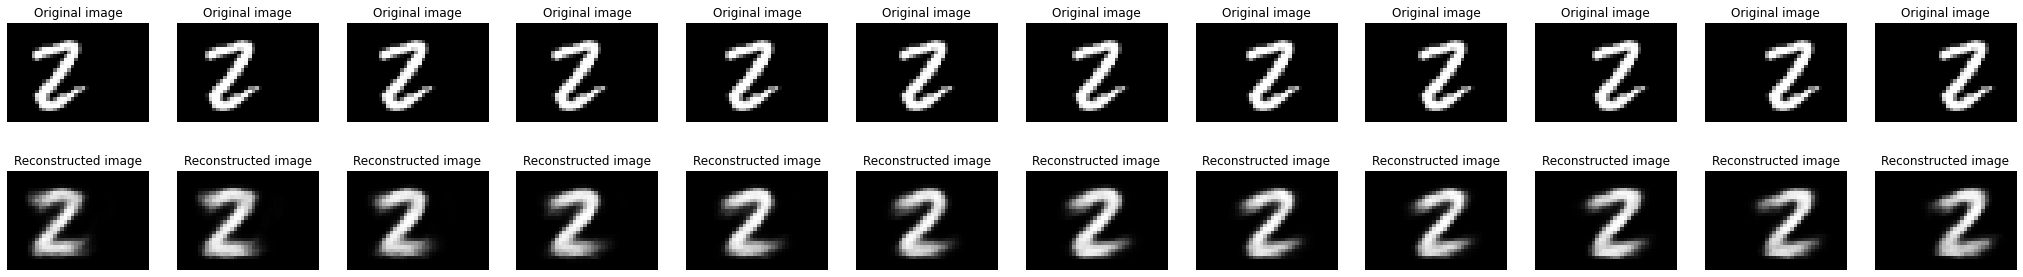

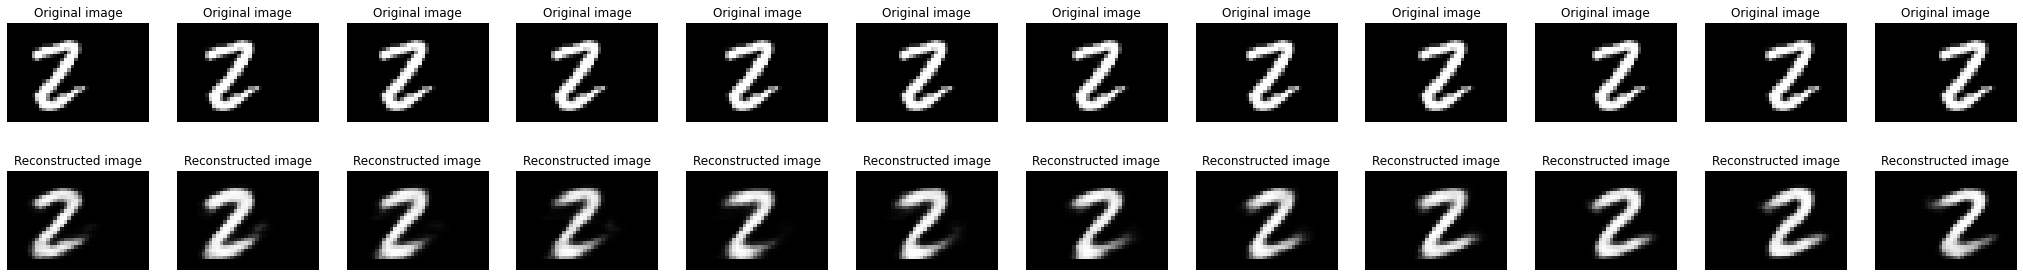

In [29]:
Performance_time,Performance_loss=performance(Performance_dim)

In [31]:
performance = pd.DataFrame({'Dimension': Performance_dim,'loss': Performance_loss, 'time':Performance_time})
performance

,Dimension,loss,time
0,2,0.160396,64.921492
1,3,0.148111,64.410172
2,5,0.132979,64.870084
3,10,0.112483,66.082408


## How to identify the underlying meaning of latent variables in chosen latent space? 

In [37]:
tf.random.set_seed(42)
np.random.seed(42)
#############################################
#according to the previous outcome 
#the latent space dimensionality determined
codings_size = 3

inputs = keras.layers.Input(shape=[28, 40])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])
###########################################################################
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 40, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 40])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
###########################################################################
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
###########################################################################
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 1120.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop",metrics=[rounded_accuracy])


history = variational_ae.fit(x_train, x_train, epochs=10,
                             validation_data=(x_valid, x_valid),verbose=0)
latent=variational_encoder(x_valid)[2].numpy()

In [420]:
#summary the statistics of latent variables
df=pd.DataFrame(latent)
summarys=df.describe()
summarys

,0,1,2
count,11496.000000,11496.000000,11496.000000
mean,0.117526,0.076956,0.020773
std,1.128110,1.236011,1.251420
min,-4.799901,-3.665053,-3.318700
25%,-0.614856,-0.736806,-0.867462
50%,0.132538,0.115012,-0.127121
75%,0.887224,0.875265,0.839375
max,3.386814,4.951547,3.556249


### The sampling about quantitive method

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(10, 10))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.title('Index '+str(index+1))
        plt.axis("off")

In [273]:
#The adjusted latent variables of quantitive method to reveal the underlying meaning of latent variables.
latent_adjusted=np.zeros((12,3))
latent_adjusted1=np.zeros((12,3))
latent_adjusted2=np.zeros((12,3))


latent_adjusted[:,0]=latent[12:24,0]
latent_adjusted1[:,1]=latent[12:24,1]
latent_adjusted2[:,2]=latent[12:24,2]

for i in range(12):
    latent_adjusted[i,1:3]=latent[12,1:3]
    latent_adjusted1[i,[0,2]]=latent[12,[0,2]]
    latent_adjusted2[i,[0,1]]=latent[12,[0,1]]
    
latent_adjusted.sort(axis=0)
latent_adjusted1.sort(axis=0)
latent_adjusted2.sort(axis=0)

In [278]:
latent_adjusted[0][0]=-2.57298064
latent_adjusted[1][0]=-2.04883242
latent_adjusted[2][0]=-1.62228346
latent_adjusted[3][0]=-1.21399832
latent_adjusted[4][0]=-0.88
latent_adjusted[5][0]=-0.6097945 
latent_adjusted[6][0]=-0.4
latent_adjusted[7][0]=0.
latent_adjusted[8][0]=0.61484993
latent_adjusted[9][0]=1.05115068
latent_adjusted[10][0]=1.89177716
latent_adjusted[11][0]=2.01882434

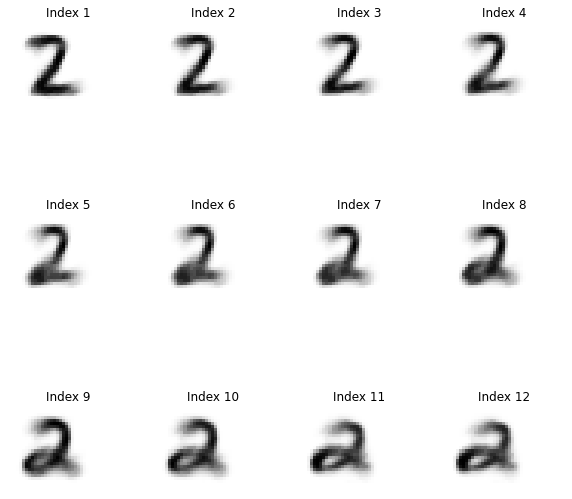

In [313]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjusted)
#reconstruction procedure via decoder process.
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit2_latent0.jpg')

In [314]:
latent_adjusted1[0][1]=-2.57298064
latent_adjusted1[1][1]=-1.92527676
latent_adjusted1[2][1]=-1.55
latent_adjusted1[3][1]=-0.88
latent_adjusted1[4][1]=-0.5
latent_adjusted1[5][1]=-0.04811881
latent_adjusted1[6][1]=0.63788891
latent_adjusted1[7][1]=1.16150331
latent_adjusted1[8][1]=1.5
latent_adjusted1[9][1]=1.96672893
latent_adjusted1[10][1]=2.69096398
latent_adjusted1[11][1]=3


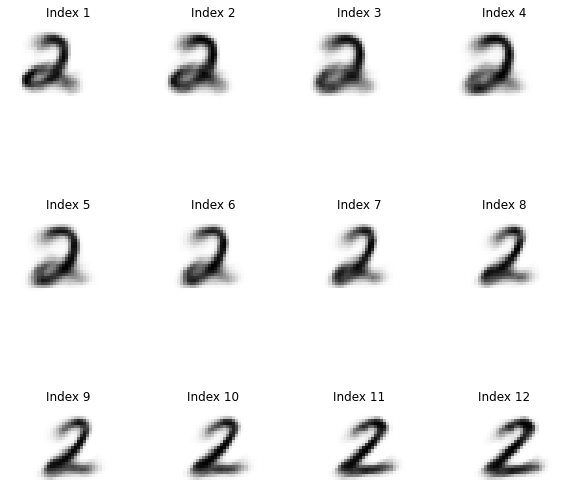

In [315]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjusted1)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit2_latent1.jpg')

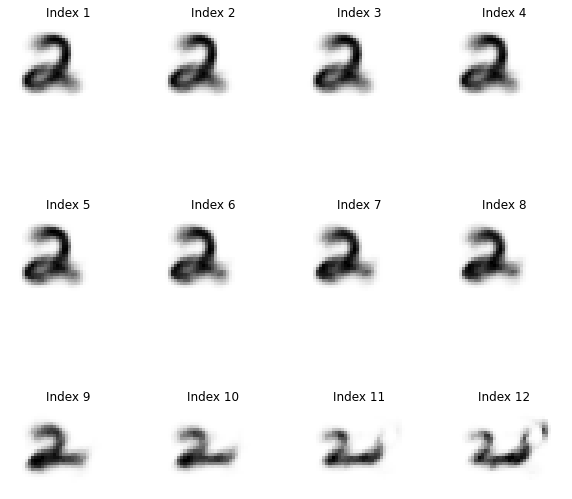

In [316]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_adjusted2)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
#plt.savefig('digit2_latent2.jpg')

Here are original values in latent space.

In [283]:
latent_copy=np.zeros((12,3))
latent_copy1=np.zeros((12,3))
latent_copy2=np.zeros((12,3))


latent_copy[:,0]=latent[24:36,0]
latent_copy1[:,1]=latent[24:36,1]
latent_copy2[:,2]=latent[24:36,2]

for i in range(12):
    latent_copy[i,1:3]=latent[24,1:3]
    latent_copy1[i,[0,2]]=latent[24,[0,2]]
    latent_copy2[i,[0,1]]=latent[24,[0,1]]
    
latent_copy.sort(axis=0)
latent_copy1.sort(axis=0)
latent_copy2.sort(axis=0)

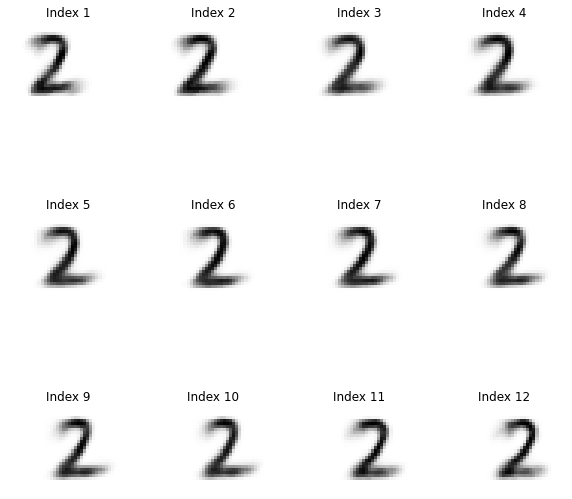

In [303]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent[24:36])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

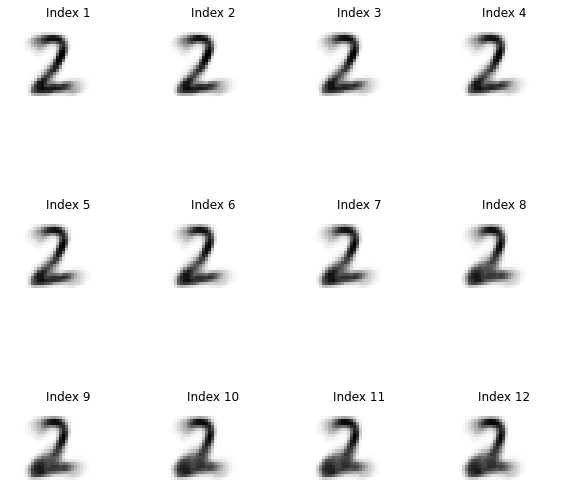

In [285]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

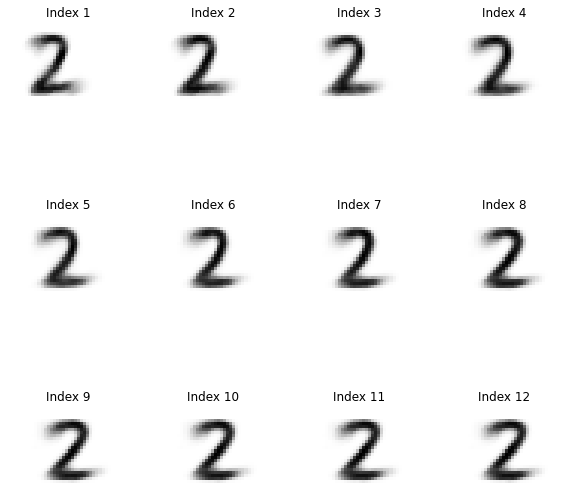

In [286]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy1)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

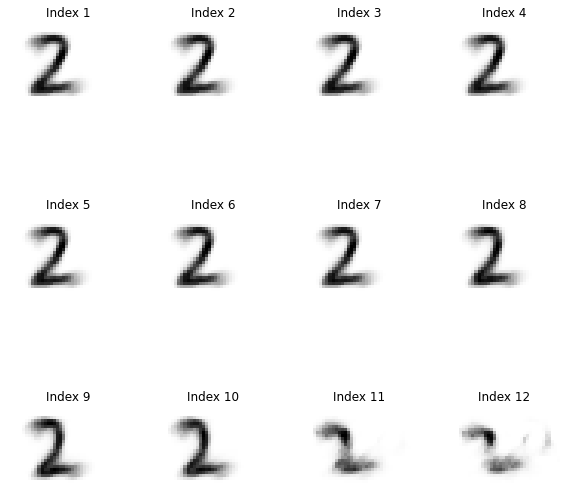

In [287]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy2)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

In [307]:
latent_copy=np.zeros((12,3))
latent_copy1=np.zeros((12,3))
latent_copy2=np.zeros((12,3))


latent_copy[:,0]=latent[36:48,0]
latent_copy1[:,1]=latent[36:48,1]
latent_copy2[:,2]=latent[36:48,2]

for i in range(12):
    latent_copy[i,1:3]=latent[36,1:3]
    latent_copy1[i,[0,2]]=latent[36,[0,2]]
    latent_copy2[i,[0,1]]=latent[36,[0,1]]
    
latent_copy.sort(axis=0)
latent_copy1.sort(axis=0)
latent_copy2.sort(axis=0)

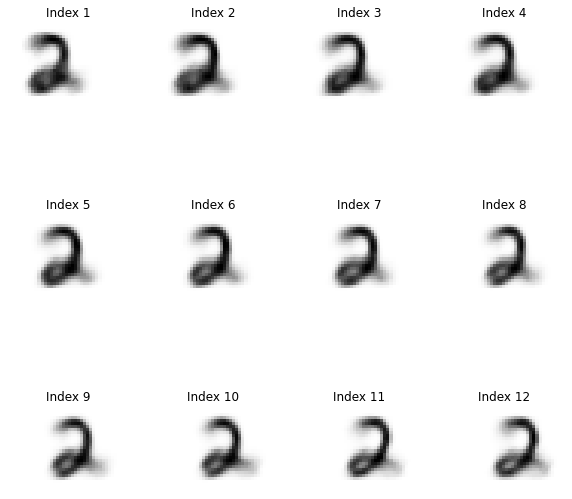

In [308]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent[36:48])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

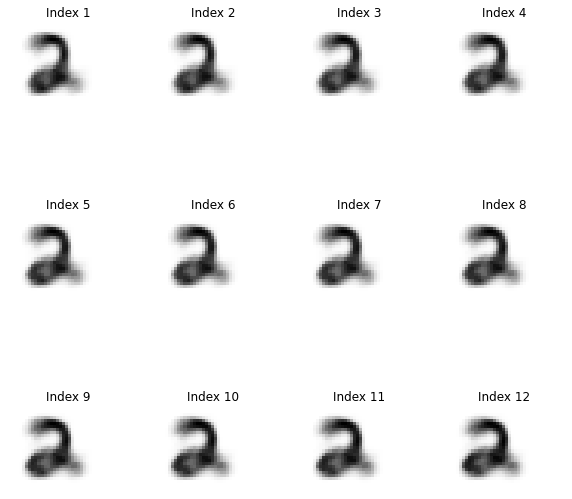

In [309]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

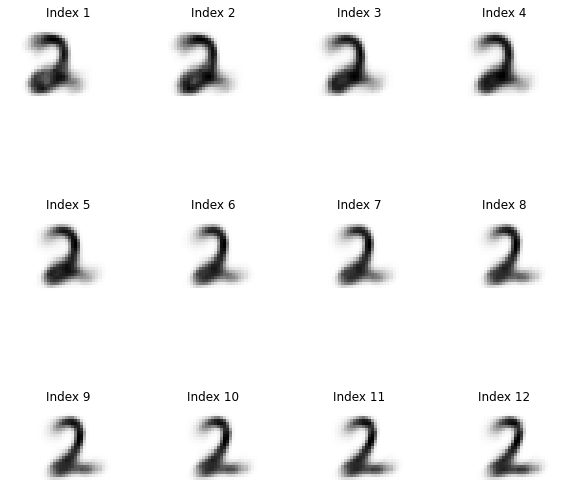

In [310]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy1)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

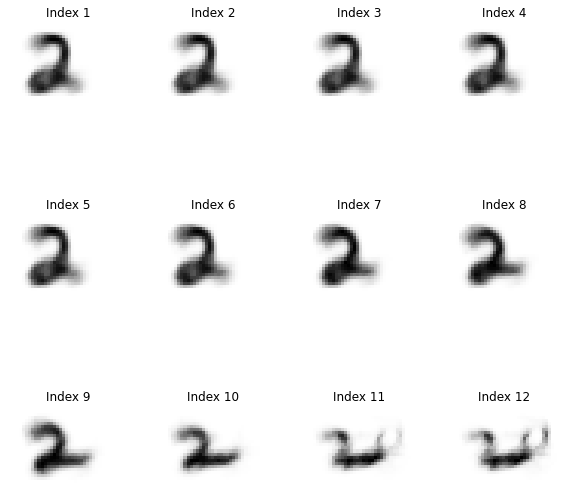

In [311]:
tf.random.set_seed(42)
#shape=[number,latent-dimension-size]
#codings = tf.random.normal(shape=[12, 5])
codings=tf.constant(latent_copy2)
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)

## What is the motion trajectory of digit 1 in latent space?

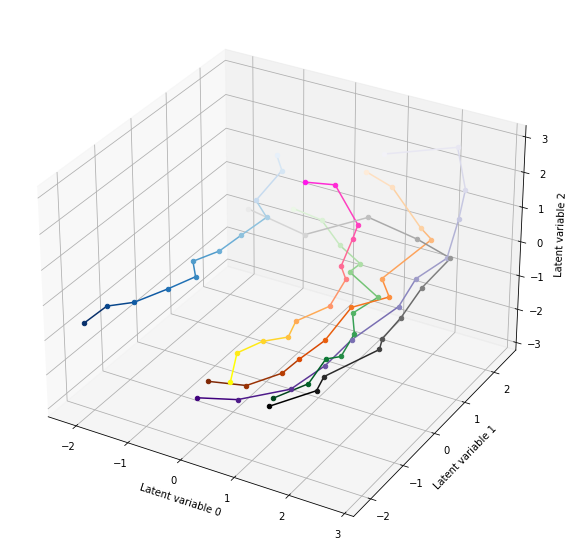

In [421]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

np.random.seed(11)
randoms=np.random.randint(0,958,6)

cmap_list=['Blues_r','Purples_r','Greens_r','Oranges_r','spring_r','gray']
fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for i in range(6):
    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=0, vmax=12)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=plt.get_cmap(cmap_list[i]))
    for j in range(12): 
        colorVal = scalarMap.to_rgba(j)
        ax.scatter(latent[randoms[i]*12+j,0],latent[randoms[i]*12+j,1],latent[randoms[i]*12+j,2],color=colorVal)
    for k in range(11):
        colorVal = scalarMap.to_rgba(k)
        ax.plot3D(latent[randoms[i]*12+k:randoms[i]*12+k+2,0],latent[randoms[i]*12+k:randoms[i]*12+k+2,1],latent[randoms[i]*12+k:randoms[i]*12+k+2,2],color=colorVal)  
ax.set_xlabel('Latent variable 0')
ax.set_ylabel('Latent variable 1')
ax.set_zlabel('Latent variable 2')
#plt.savefig('digit2_motion_3d.jpg')
plt.show()



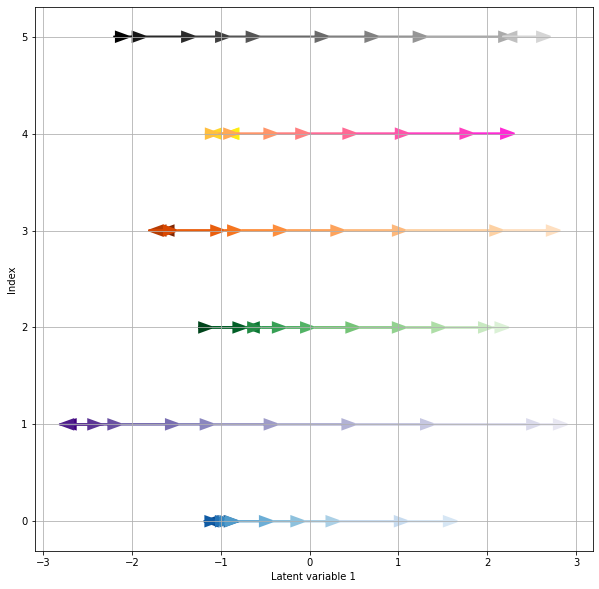

In [422]:
cmap_list=['Blues_r','Purples_r','Greens_r','Oranges_r','spring_r','gray']
plt.figure(figsize=(10, 10))
plt.grid(True)
ids=0
for i in range(6):
    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=0, vmax=12)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=plt.get_cmap(cmap_list[i]))
    for j in range(11):        
        colorVal = scalarMap.to_rgba(j)
        plt.arrow(latent[randoms[i]*12+j][2], i, latent[randoms[i]*12+j+1,2]-latent[randoms[i]*12+j,2], 0, 
                  length_includes_head=True, head_width=0.1, lw=2,
                  color=colorVal)
    ids+=1
plt.xlabel('Latent variable 1')
plt.ylabel('Index')
plt.savefig('digit2_motion_1d.jpg')

## Futher Study: Whether we can apply T-SNE to achieve meaningful representation and visualization ?

In [ ]:
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(latent)
digit2_randoms=np.random.randint(0,int(latent.shape[0]/12),6)
cmap_list=['Blues_r','Purples_r','Greens_r','Oranges_r','spring_r','gray_r']
plt.figure(figsize=(10, 10))
plt.grid(True)

for i in range(6):
    cmap = plt.cm.jet
    cNorm  = colors.Normalize(vmin=0, vmax=12)
    scalarMap = cmx.ScalarMappable(norm=cNorm,cmap=plt.get_cmap(cmap_list[i]))
    for j in range(11):        
        colorVal = scalarMap.to_rgba(j)
        plt.arrow(X_tsne[digit2_randoms[i]*12+j][1], X_tsne[digit2_randoms[i]*12+j][0],
                  X_tsne[digit2_randoms[i]*12+j+1,1]-X_tsne[digit2_randoms[i]*12+j,1],
                  X_tsne[digit2_randoms[i]*12+j+1,0]-X_tsne[digit2_randoms[i]*12+j,0],
                length_includes_head=True, head_width=1, lw=2, color=colorVal)
plt.xlabel('Latent variable 1')
plt.ylabel('Latent variable 0')
#plt.savefig('digit2_motion_2d.jpg')